In [1]:
import pandas as pd
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

In [2]:
retained_cols = ["suburb", "suburb_code", "mean_income_2011_12", "mean_income_2012_13", "mean_income_2013_14",
                 "mean_income_2014_15", "mean_income_2015_16", "mean_income_2016_17", "mean_income_2017_18"]
income_df = pd.read_csv("../data/curated/Income.csv", usecols=retained_cols)

income_df = pd.melt(income_df, id_vars=["suburb", "suburb_code"])

# Create year column 
for i in range(len(income_df)):
    if income_df.loc[i, "variable"] == "mean_income_2011_12":
        income_df.loc[i, "year"] = 2011
    elif income_df.loc[i, "variable"] == "mean_income_2012_13":
        income_df.loc[i, "year"] = 2012
    elif income_df.loc[i, "variable"] == "mean_income_2013_14":
        income_df.loc[i, "year"] = 2013
    elif income_df.loc[i, "variable"] == "mean_income_2014_15":
        income_df.loc[i, "year"] = 2014
    elif income_df.loc[i, "variable"] == "mean_income_2015_16":
        income_df.loc[i, "year"] = 2015
    elif income_df.loc[i, "variable"] == "mean_income_2016_17":
        income_df.loc[i, "year"] = 2016
    elif income_df.loc[i, "variable"] == "mean_income_2017_18":
        income_df.loc[i, "year"] = 2017

# Predict income for 2018-2021
sa2_list = [i for i in income_df["suburb"].unique()]
income_predictions = pd.DataFrame(columns =["suburb", "lower value", "upper value", "predictions"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i in sa2_list:
        curr_suburb = income_df[income_df["suburb"] == i]
        y = curr_suburb["value"]

        ARMAmodel = SARIMAX(y, order=(1,0,1))
        ARMAmodel = ARMAmodel.fit(disp=0)

        y_pred = ARMAmodel.get_forecast(4)
        y_pred_df = y_pred.conf_int(alpha=0.05) 
        y_pred_df["predictions"] = ARMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
        y_pred_df["year"] = [2018, 2019, 2020, 2021]

        y_pred_df["suburb"] = i 

        income_predictions = pd.concat([income_predictions, y_pred_df])

# Combine sourced and predicted income data
income_predictions = income_predictions.rename(columns={"predictions": "value"}).drop(["lower value", "upper value"], axis=1).reset_index(drop=True)
income_df = income_df.drop(["suburb_code", "variable"], axis=1).reset_index(drop=True)
income_df = pd.concat([income_df, income_predictions], ignore_index=True)
income_df.to_csv("../data/curated/Final_Income.csv")
weekly_income_df = income_df.copy()

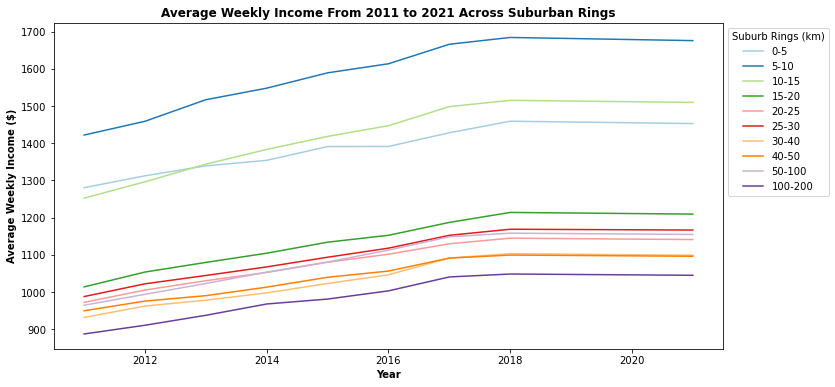

In [3]:
rental_df = pd.read_csv("../data/curated/Final_Preprocessed_Scraped_Rental.csv")
historical_rental_df = pd.read_csv("../data/curated/Fixed_Weekly_Median_Suburb_Rents.csv")

# Filter instances from 2011-2021
historical_rental_df = historical_rental_df[historical_rental_df["Year"] >= 2011] 

# Convert suburb names to lowercase
historical_rental_df["Suburb"] = historical_rental_df["Suburb"].str.lower()

# Group instances by year and suburb in historical rental dataset
historical_rental_df = historical_rental_df.groupby(["Year", "Suburb"], as_index=False)["Median"].mean()

# Compute distance to CBD for each suburb in the income dataset
distance_to_cbd_df = rental_df.groupby("suburb", as_index=False)["distance_to_cbd"].mean()
weekly_income_df = weekly_income_df.groupby(["year", "suburb"], as_index=False)["value"].mean()
weekly_income_df = pd.merge(weekly_income_df, distance_to_cbd_df, on="suburb")

# Compute average weekly income for each instance
weekly_income_df["weekly_income"] = weekly_income_df["value"]/52
income_rent_df = weekly_income_df.copy()

# Bin suburbs based on distance to CBD 
weekly_income_df["bins"] = pd.cut(weekly_income_df["distance_to_cbd"], [0, 5, 10, 15, 20, 25, 30, 40, 50, 100, 200], 
                         labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "40-50", "50-100", "100-200"])

# Group instances by year and distance to CBD bins
weekly_income_df = weekly_income_df.groupby(["year", "bins"], as_index=False)["weekly_income"].mean()

# Create a time series plot for average weekly income from 2011-2021
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=weekly_income_df, x="year", y="weekly_income", hue="bins", palette="Paired", legend=False)
ax.set_xlabel("Year", fontweight="bold")
ax.set_ylabel("Average Weekly Income ($)", fontweight="bold")
plt.legend(title="Suburb Rings (km)", loc="upper right", bbox_to_anchor=(1.165, 1), 
           labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "40-50", "50-100", "100-200"])
plt.title("Average Weekly Income From 2011 to 2021 Across Suburban Rings", fontweight="bold")
plt.savefig("../plots/average_weekly_income_time_series_line_plot.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

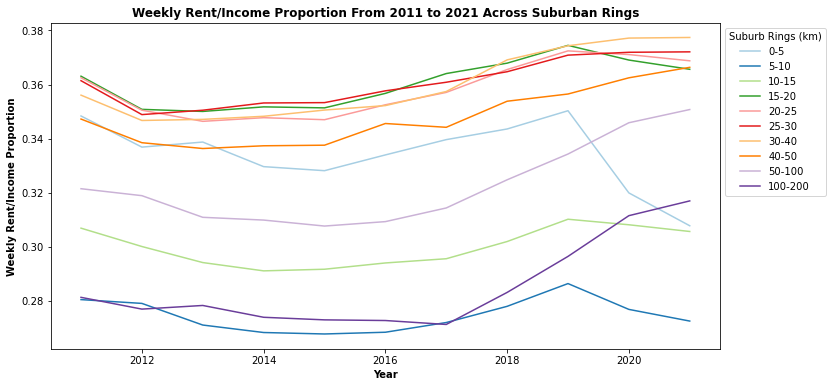

In [4]:
# Compute weekly rent/income proportion
income_rent_df = pd.merge(income_rent_df, historical_rental_df, left_on=["suburb", "year"], right_on=["Suburb", "Year"]).drop(["Year", "Suburb"], axis=1)
income_rent_df["weekly_rent_income_proportion"] = income_rent_df["Median"]/income_rent_df["weekly_income"]

# Bin suburbs based on distance to CBD 
final_income_df = income_rent_df.copy()
final_income_df["bins"] = pd.cut(final_income_df["distance_to_cbd"], [0, 5, 10, 15, 20, 25, 30, 40, 50, 100, 200], 
                         labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "40-50", "50-100", "100-200"])

# Group instances by year and distance to CBD bins
final_income_df = final_income_df.groupby(["year", "bins"], as_index=False)["weekly_rent_income_proportion"].mean()

# Create a time series plot for weekly rent/income proportion from 2011-2021
plt.figure(figsize=(12,6))
ax = sns.lineplot(data=final_income_df, x="year", y="weekly_rent_income_proportion", hue="bins", palette="Paired", legend=False)
ax.set_xlabel("Year", fontweight="bold")
ax.set_ylabel("Weekly Rent/Income Proportion", fontweight="bold")
plt.legend(title="Suburb Rings (km)", loc="upper right", bbox_to_anchor=(1.165, 1), 
           labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-40", "40-50", "50-100", "100-200"])
plt.title("Weekly Rent/Income Proportion From 2011 to 2021 Across Suburban Rings", fontweight="bold")
plt.savefig("../plots/weekly_rent_income_proportion_time_series_line_plot.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

C:\Users\benja\AppData\Local\Temp/ipykernel_14328/3969038090.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks(), size=20)


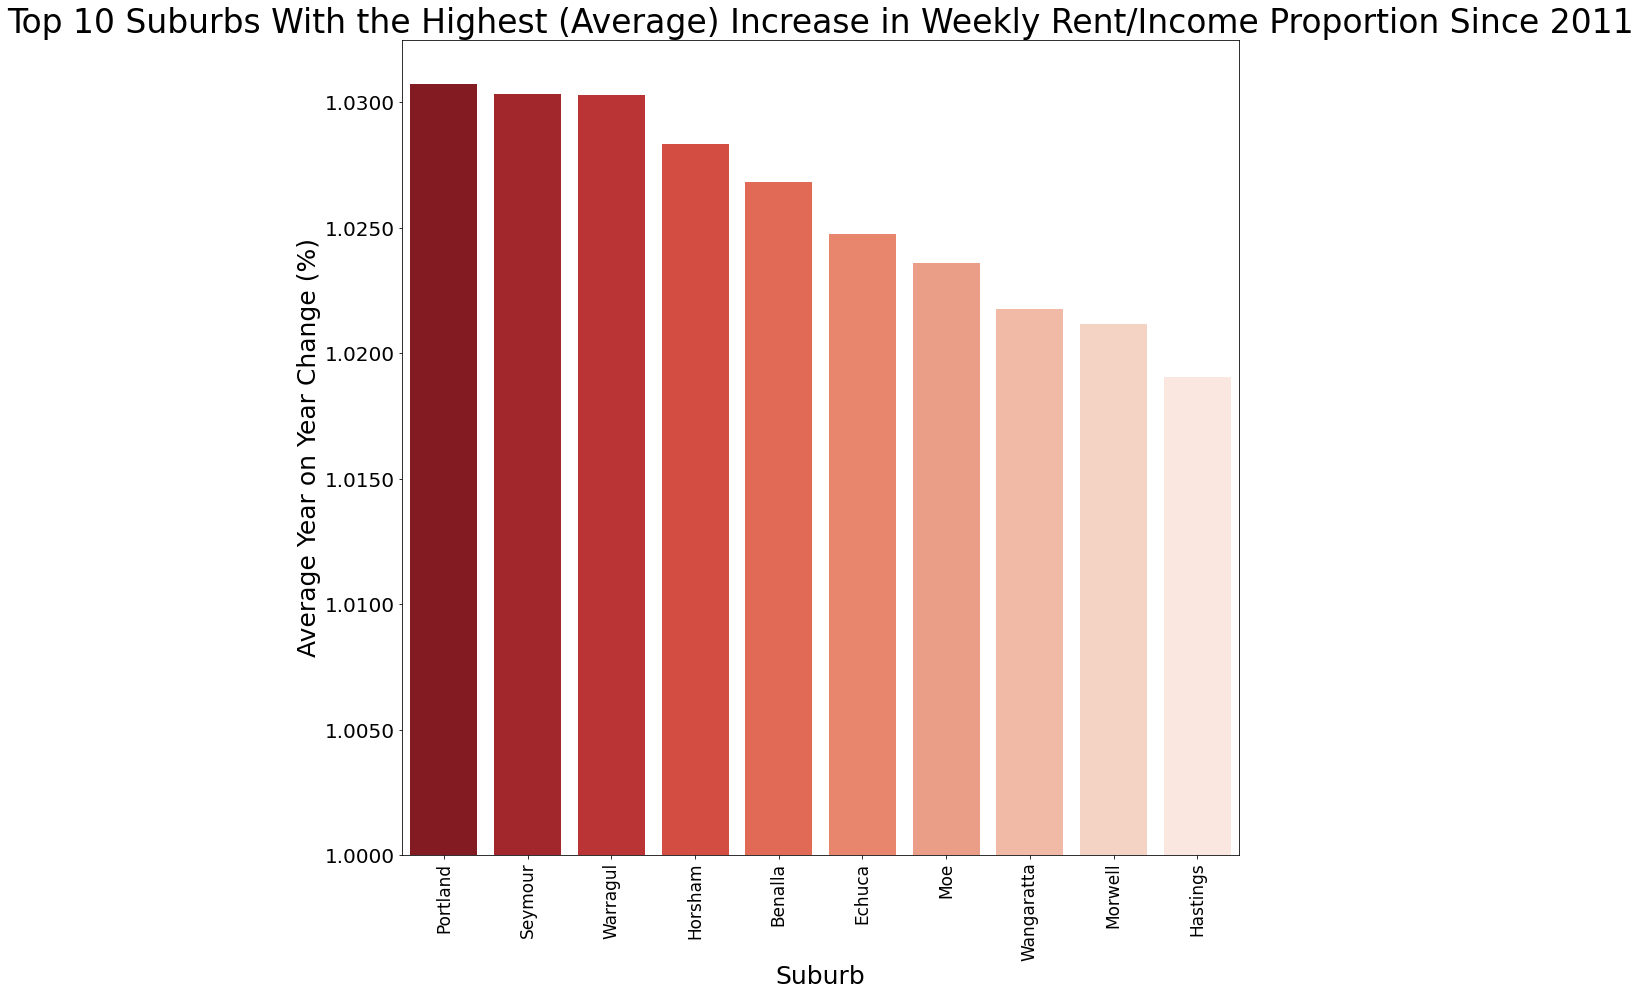

In [5]:
# Calculate average percentage change in weekly rent/income proportion by suburb
percentage_changes = income_rent_df.copy()
percentage_changes.sort_values(["suburb", "year"], inplace=True, ascending=[True, True])
percentage_changes["percentage_change"] = (percentage_changes.groupby("suburb")["weekly_rent_income_proportion"].apply(pd.Series.pct_change) + 1)
percentage_changes_mean = percentage_changes.groupby(["suburb"], as_index=False).mean().sort_values(by=["percentage_change"], ascending=False)

# Capitalise suburb names
percentage_changes_mean["suburb"] = percentage_changes_mean["suburb"].str.title()

# Obtain top ten suburbs with highest and lowest average percentage change in weekly rent/income proportion respectively
top_ten = percentage_changes_mean.head(10).reset_index(drop=True)
bottom_ten = percentage_changes_mean.tail(10).reset_index(drop=True)

# Create bar plot for top ten suburbs with highest average percentage change in weekly rent/income proportion
plt.figure(figsize=(15,15)) 
fig = sns.barplot(data=top_ten, x="suburb", y="percentage_change", palette="Reds_r", dodge=False)
fig.set(ylim=(1.0000, 1.0325))
fig.set_xlabel("Suburb", size=25)
fig.set_ylabel("Average Year on Year Change (%)", size=25)

fig.set_xticklabels([i for i in top_ten["suburb"]], size=17, rotation=90)
fig.set_yticklabels(fig.get_yticks(), size=20)
fig.yaxis.set_major_formatter(FormatStrFormatter("%.4f"))
fig.set_title("Top 10 Suburbs With the Highest (Average) Increase in Weekly Rent/Income Proportion Since 2011", size=33)
plt.savefig("../plots/top_ten_increase_weekly_rent_income.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

C:\Users\benja\AppData\Local\Temp/ipykernel_14328/2923070318.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks(), size=20)


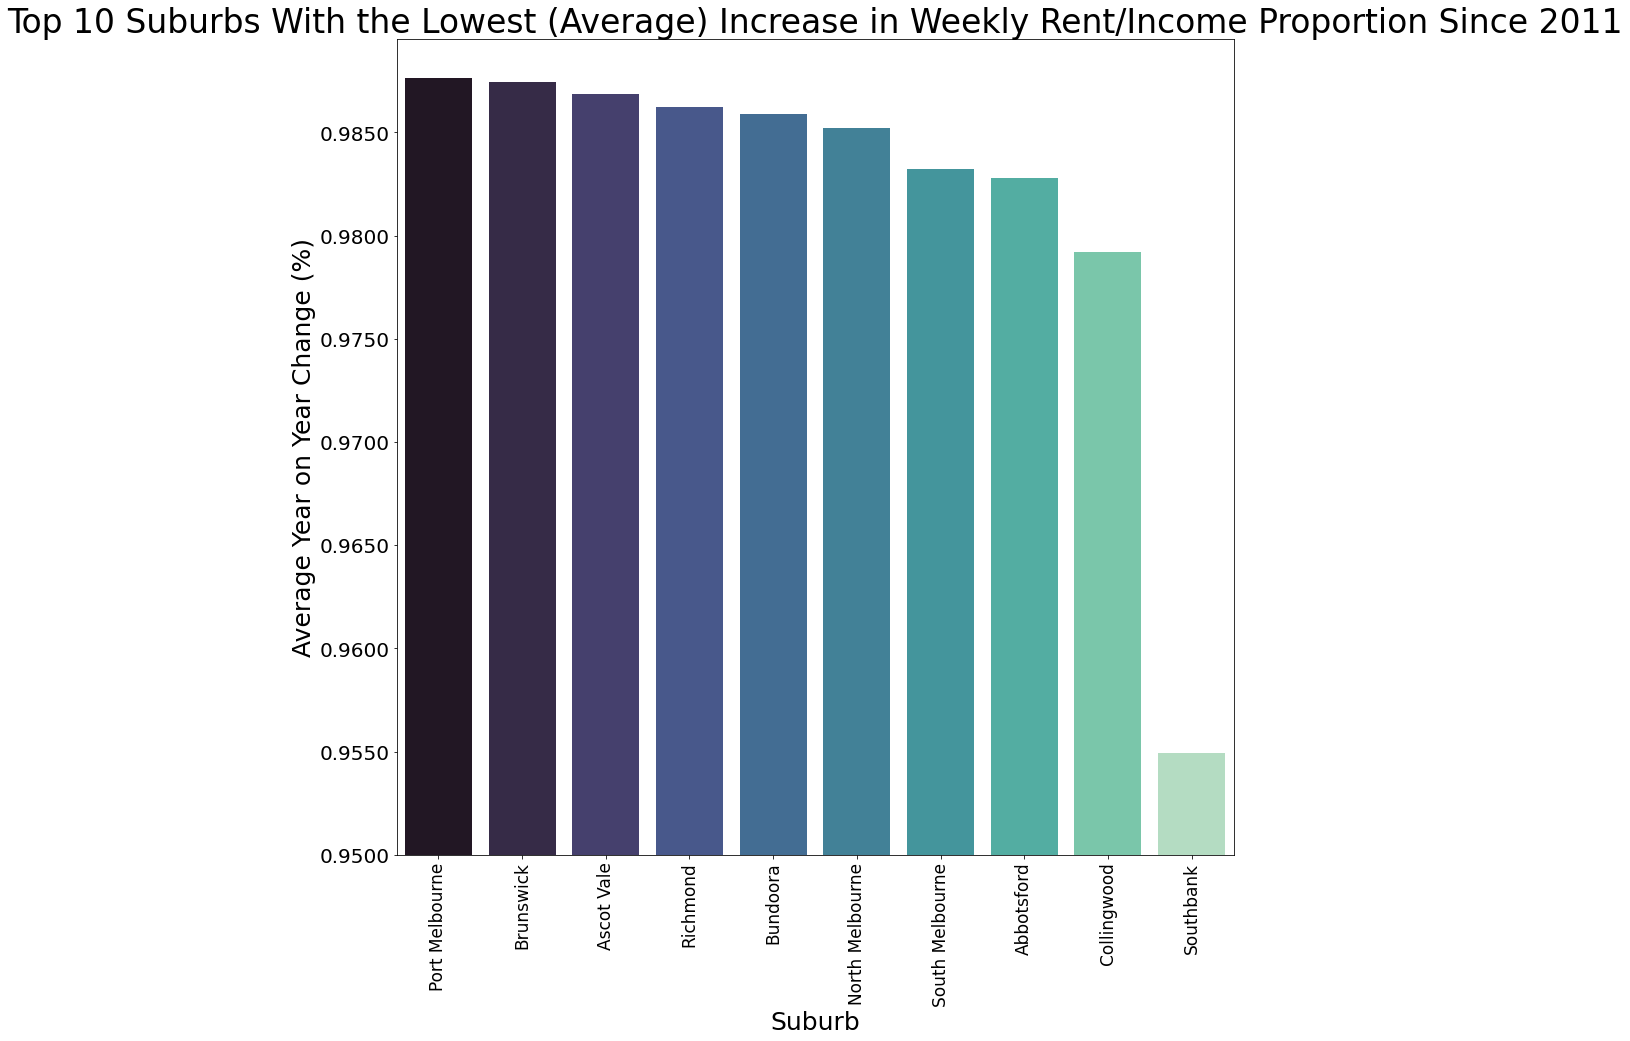

In [6]:
# Create bar plot for top ten suburbs with lowest average percentage change in weekly rent/income proportion
plt.figure(figsize=(15,15)) 
fig = sns.barplot(data=bottom_ten, x="suburb", y="percentage_change", palette="mako", dodge=False)
fig.set(ylim=(0.9500, 0.9895))
fig.set_xlabel("Suburb", size=25)
fig.set_ylabel("Average Year on Year Change (%)", size=25)

fig.set_xticklabels([i for i in bottom_ten["suburb"]], size=17, rotation=90)
fig.set_yticklabels(fig.get_yticks(), size=20)
fig.yaxis.set_major_formatter(FormatStrFormatter("%.4f"))
fig.set_title("Top 10 Suburbs With the Lowest (Average) Increase in Weekly Rent/Income Proportion Since 2011", size=33)
plt.savefig("../plots/bottom_ten_increase_weekly_rent_income.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

C:\Users\benja\AppData\Local\Temp/ipykernel_14328/2235755910.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks(), size=20)


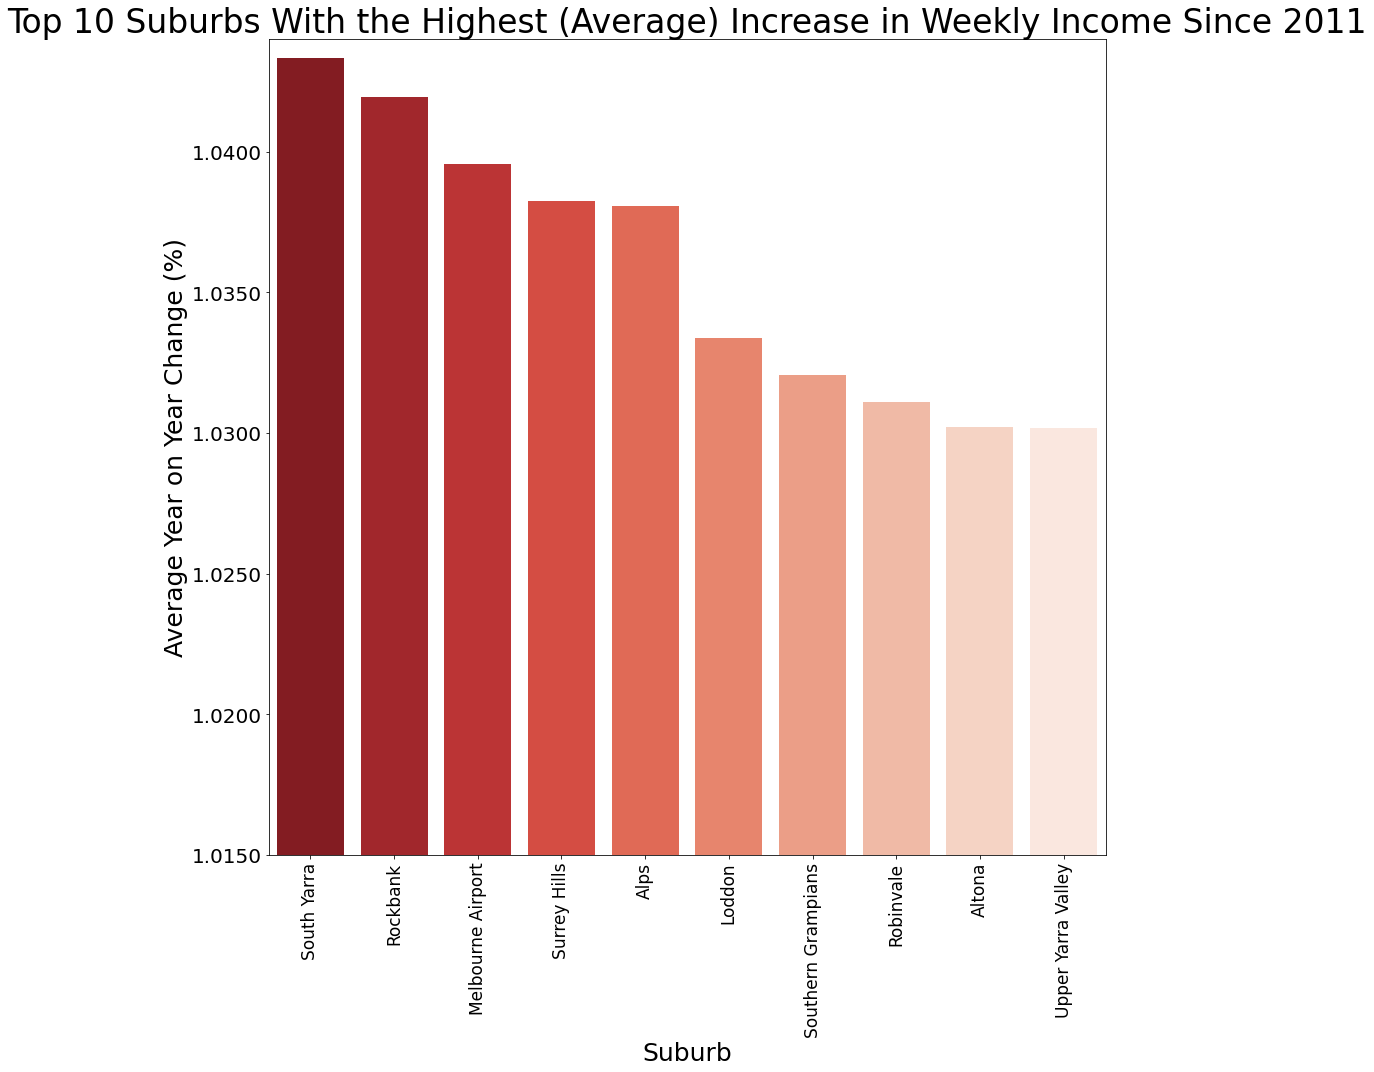

In [7]:
# Compute weekly income for each instance
income_df["weekly_income"] = income_df["value"]/52

# Calculate average percentage change in weekly income by suburb
percentage_changes = income_df.copy()
percentage_changes.sort_values(["suburb", "year"], inplace=True, ascending=[True, True])
percentage_changes["percentage_change"] = (percentage_changes.groupby("suburb")["weekly_income"].apply(pd.Series.pct_change) + 1)
percentage_changes_mean = percentage_changes.groupby(["suburb"], as_index=False).mean().sort_values(by=["percentage_change"], ascending=False)

# Capitalise suburb names
percentage_changes_mean["suburb"] = percentage_changes_mean["suburb"].str.title()

# Obtain top ten suburbs with highest and lowest average percentage change in weekly income respectively
top_ten = percentage_changes_mean.head(10).reset_index(drop=True)
bottom_ten = percentage_changes_mean.tail(10).reset_index(drop=True)

# Create bar plot for top ten suburbs with highest average percentage change in weekly income
plt.figure(figsize=(15,15)) 
fig = sns.barplot(data=top_ten, x="suburb", y="percentage_change", palette="Reds_r", dodge=False)
fig.set(ylim=(1.0150, 1.044))
fig.set_xlabel("Suburb", size=25)
fig.set_ylabel("Average Year on Year Change (%)", size=25)

fig.set_xticklabels([i for i in top_ten["suburb"]], size=17, rotation=90)
fig.set_yticklabels(fig.get_yticks(), size=20)
fig.yaxis.set_major_formatter(FormatStrFormatter("%.4f"))
fig.set_title("Top 10 Suburbs With the Highest (Average) Increase in Weekly Income Since 2011", size=33)
plt.savefig("../plots/top_ten_increase_weekly_income.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()

C:\Users\benja\AppData\Local\Temp/ipykernel_14328/3932799101.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_yticklabels(fig.get_yticks(), size=20)


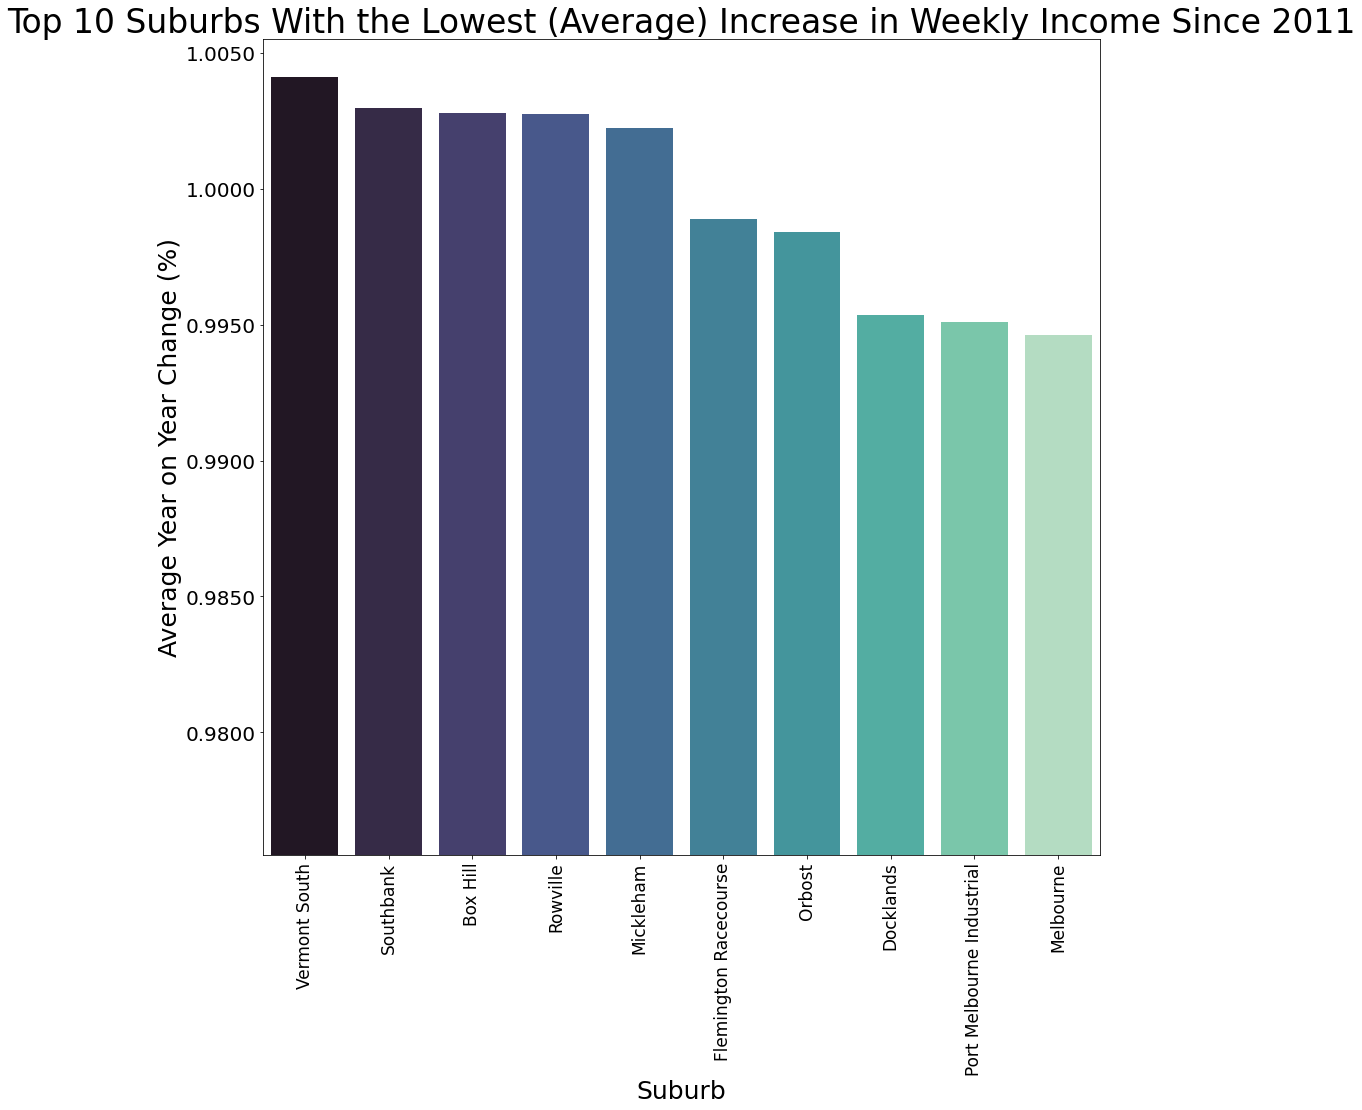

In [8]:
# Create bar plot for top ten suburbs with lowest average percentage change in weekly income
plt.figure(figsize=(15,15)) 
fig = sns.barplot(data=bottom_ten, x="suburb", y="percentage_change", palette="mako", dodge=False)
fig.set(ylim=(0.9755, 1.0055))
fig.set_xlabel("Suburb", size=25)
fig.set_ylabel("Average Year on Year Change (%)", size=25)

fig.set_xticklabels([i for i in bottom_ten["suburb"]], size=17, rotation=90)
fig.set_yticklabels(fig.get_yticks(), size=20)
fig.yaxis.set_major_formatter(FormatStrFormatter("%.4f"))
fig.set_title("Top 10 Suburbs With the Lowest (Average) Increase in Weekly Income Since 2011", size=33)
plt.savefig("../plots/bottom_ten_increase_weekly_income.png", transparent=True, facecolor="white", bbox_inches="tight")
plt.show()
plt.close()